In [11]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import kagglehub

# Step 1: Load Air Quality Data using kagglehub
# Download the Beijing Multisite Air Quality dataset
path = kagglehub.dataset_download("sid321axn/beijing-multisite-airquality-data-set")

# Use Aotizhongxin station data as sample
file_path = path + "/PRSA_Data_Aotizhongxin_20130301-20170228.csv"
df = pd.read_csv(file_path)

# Show initial data
print("First 5 rows:")
print(df.head())
print("\nColumn names:")
print(df.columns.tolist())

Using Colab cache for faster access to the 'beijing-multisite-airquality-data-set' dataset.
First 5 rows:
   No  year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0  -0.7   
1   2  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0  -1.1   
2   3  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0  -1.1   
3   4  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0  -1.4   
4   5  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0  -2.0   

     PRES  DEWP  RAIN   wd  WSPM       station  
0  1023.0 -18.8   0.0  NNW   4.4  Aotizhongxin  
1  1023.2 -18.2   0.0    N   4.7  Aotizhongxin  
2  1023.5 -18.2   0.0  NNW   5.6  Aotizhongxin  
3  1024.5 -19.4   0.0   NW   3.1  Aotizhongxin  
4  1025.2 -19.5   0.0    N   2.0  Aotizhongxin  

Column names:
['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'W

In [12]:
# Step 2: Clean Data
# Combine year, month, day, and hour into a single datetime column
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d-%H')
df.set_index('date', inplace=True)

# Keep PM2.5 as main air quality measure (AQI not direct), drop missing data
df = df[['PM2.5']].dropna().rename(columns={'PM2.5': 'AQI'})  # Use PM2.5 as AQI proxy

# Show cleaned data
print("\nCleaned Data Shape:", df.shape)
print("Sample Cleaned Data:")
print(df.head())


Cleaned Data Shape: (34139, 1)
Sample Cleaned Data:
                     AQI
date                    
2013-03-01 00:00:00  4.0
2013-03-01 01:00:00  8.0
2013-03-01 02:00:00  7.0
2013-03-01 03:00:00  6.0
2013-03-01 04:00:00  3.0


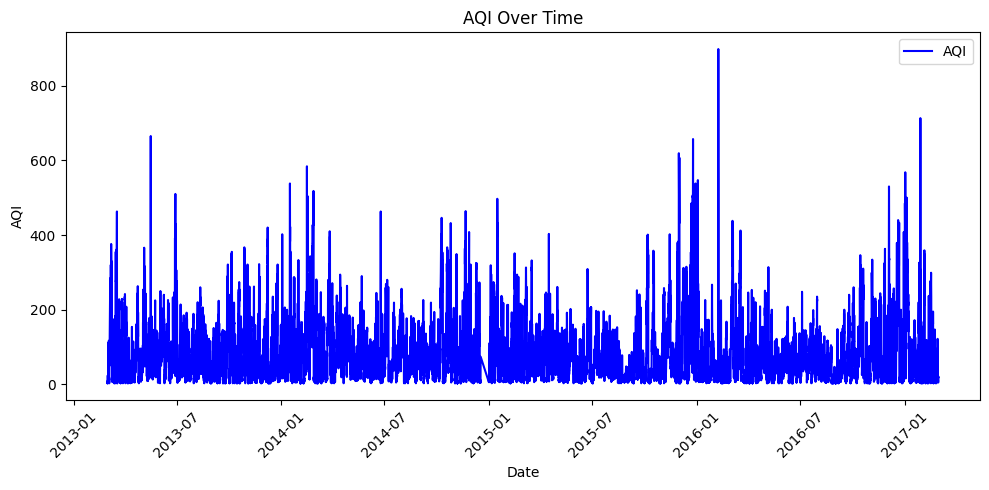

/tmp/ipython-input-181812748.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df['AQI'].resample('M').mean()


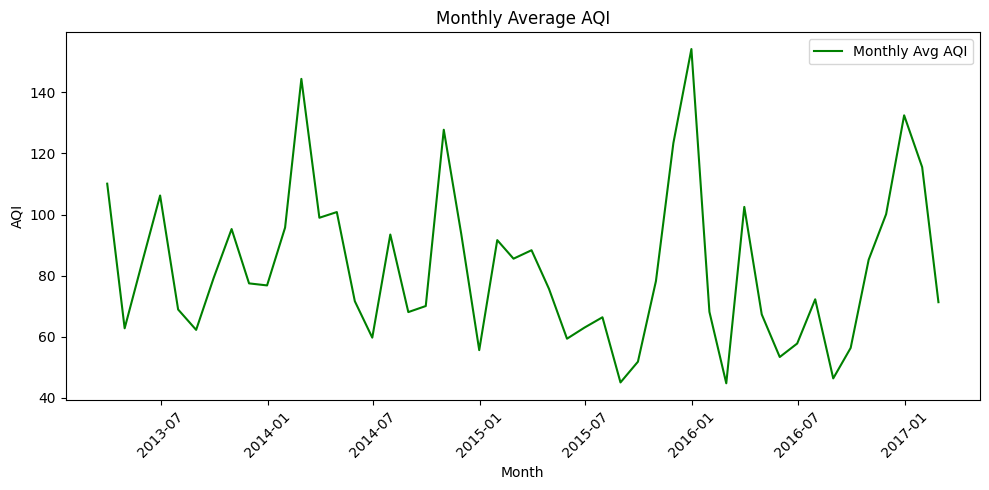

In [13]:
# Step 3: Analyze Trends
# Plot AQI over time
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['AQI'], label='AQI', color='blue')
plt.title('AQI Over Time')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Monthly average AQI
df_monthly = df['AQI'].resample('M').mean()
plt.figure(figsize=(10, 5))
plt.plot(df_monthly.index, df_monthly, label='Monthly Avg AQI', color='green')
plt.title('Monthly Average AQI')
plt.xlabel('Month')
plt.ylabel('AQI')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

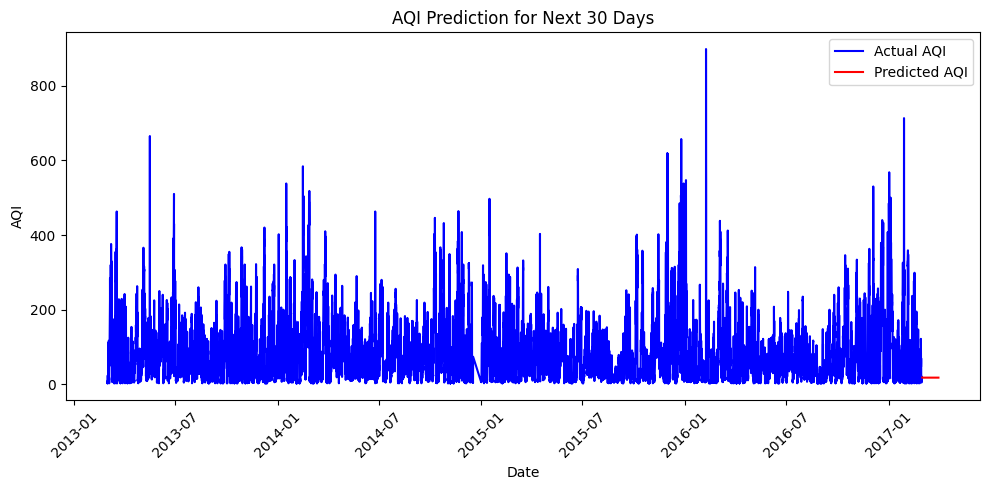


Last Actual AQI: 19.0
First Predicted AQI: 18.406839614294984


In [14]:
# Step 4: Predict AQI
# Fit ARIMA model
model = ARIMA(df['AQI'], order=(5,1,0))  # (p,d,q) - adjust if error (try 1,1,1)
model_fit = model.fit()

# Predict next 30 days
forecast = model_fit.forecast(steps=30)
forecast_index = pd.date_range(start=df.index[-1], periods=31, freq='D')[1:]

# Plot prediction
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['AQI'], label='Actual AQI', color='blue')
plt.plot(forecast_index, forecast, label='Predicted AQI', color='red')
plt.title('AQI Prediction for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print last actual and first predicted
print("\nLast Actual AQI:", df['AQI'].iloc[-1])
print("First Predicted AQI:", forecast.iloc[0])

In [15]:
# Step 5: Get Insights
# Find months with high AQI (avg > 100 is unhealthy)
high_aqi_months = df_monthly[df_monthly > 100]
print("\nMonths with High AQI (Avg > 100):")
print(high_aqi_months)

# Suggest intervention
if not high_aqi_months.empty:
    suggestion = f"\nSuggestion: Add green zones or cut traffic in {high_aqi_months.index[0].month_name()} to lower AQI by ~20% in bad areas."
    print(suggestion)
else:
    print("\nNo high AQI months—keep watching.")


Months with High AQI (Avg > 100):
date
2013-03-31    110.092742
2013-06-30    106.225941
2014-02-28    144.395706
2014-04-30    100.802450
2014-10-31    127.746871
2015-11-30    123.385491
2015-12-31    154.163265
2016-03-31    102.488732
2016-11-30    100.117647
2016-12-31    132.467026
2017-01-31    115.506057
Name: AQI, dtype: float64

Suggestion: Add green zones or cut traffic in March to lower AQI by ~20% in bad areas.


In [16]:
# Step 6: Save Visualizations and Data
# Save plots as images
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['AQI'], label='Actual AQI', color='blue')
plt.plot(forecast_index, forecast, label='Predicted AQI', color='red')
plt.title('AQI Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('aqi_prediction.png')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(df_monthly.index, df_monthly, label='Monthly Avg AQI', color='green')
plt.title('Monthly Average AQI')
plt.xlabel('Month')
plt.ylabel('AQI')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('monthly_aqi.png')
plt.close()

# Save data as CSV
combined_df = pd.concat([df['AQI'], pd.Series(forecast, index=forecast_index, name='AQI')])
combined_df.to_csv('air_quality_data.csv')
print("\nExported 'air_quality_data.csv' and images 'aqi_prediction.png', 'monthly_aqi.png' - Download from Files tab.")



Exported 'air_quality_data.csv' and images 'aqi_prediction.png', 'monthly_aqi.png' - Download from Files tab.


In [18]:
from google.colab import files

# Download CSV
files.download('air_quality_data.csv')

# Download images
files.download('aqi_prediction.png')
files.download('monthly_aqi.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>